# PTH and PTH-FC data analysis 

#### Importing packages and making storage class

In [19]:
import pandas as pd
import csv
import string
import numpy as np
import matplotlib.pyplot as plt #for plotting
from lmfit import minimize, Parameters, Model, Parameter
import pandas as pd 
from IPython.display import display, HTML
from scipy.integrate import odeint
import seaborn as sns
sns.set_style(style='ticks')
sns.set_palette("husl")

In [2]:
#this is a class that stores the data corresponding to each curve or run in one place 
#it makes the code a little neater 
class Run:
    def __init__(self,name="",protein="",concentration=0,t=[],r=[]):
        self.name = name 
        self.protein = protein 
        self.concentration = concentration
        self.t = t 
        self.r = r 
        self.fitResult = {} 
        self.Rsqr = {}
    

Loading the data

In [3]:
#making a file list 
letters = string.ascii_uppercase 
dataDir = 'C:/Users/dexte/Desktop/pdata/'
extension = ".xls"
fileNameList = []
for i in range(0,6):
    for j in range(1,5):
        tmpName = letters[i]+str(j)
        fileNameList.append(tmpName)
fileNameList.append('G1')
fileNameList.append('G3')
fileNameList.append('H1')
fileNameList.append('H3')
fileList = [] 
for name in fileNameList:
    fileList.append(dataDir+name+extension)

In [4]:
#fileList = ['C:/Users/dexte/Desktop/pdata/A1.xls', 'C:/Users/dexte/Desktop/pdata/A2.xls', 'C:/Users/dexte/Desktop/pdata/A3.xls', 'C:/Users/dexte/Desktop/pdata/A4.xls', 'C:/Users/dexte/Desktop/pdata/B1.xls', 'C:/Users/dexte/Desktop/pdata/B2.xls', 'C:/Users/dexte/Desktop/pdata/B3.xls', 'C:/Users/dexte/Desktop/pdata/B4.xls', 'C:/Users/dexte/Desktop/pdata/C1.xls', 'C:/Users/dexte/Desktop/pdata/C2.xls', 'C:/Users/dexte/Desktop/pdata/C3.xls', 'C:/Users/dexte/Desktop/pdata/C4.xls', 'C:/Users/dexte/Desktop/pdata/D1.xls', 'C:/Users/dexte/Desktop/pdata/D2.xls', 'C:/Users/dexte/Desktop/pdata/D3.xls', 'C:/Users/dexte/Desktop/pdata/D4.xls', 'C:/Users/dexte/Desktop/pdata/E1.xls', 'C:/Users/dexte/Desktop/pdata/E2.xls', 'C:/Users/dexte/Desktop/pdata/E3.xls', 'C:/Users/dexte/Desktop/pdata/E4.xls', 'C:/Users/dexte/Desktop/pdata/F1.xls', 'C:/Users/dexte/Desktop/pdata/F2.xls', 'C:/Users/dexte/Desktop/pdata/F3.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/G1.xls', 'C:/Users/dexte/Desktop/pdata/G3.xls', 'C:/Users/dexte/Desktop/pdata/H1.xls', 'C:/Users/dexte/Desktop/pdata/H3.xls']
#this identifies the curves corresponding to PTF-Fc proteins. The other ones are the PTH
isFc = [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,0, 0, 1,0,1]

#this reads the data from all of the files, builds a Run object, and then stores it in the run_array object 
t_array = []
r_array = []
run_array = []
conc_array = []
run_num = 0
for file in fileList:
    with open(file,'r') as csvFile:
        rowNum = 1 
        fReader = csv.reader(csvFile)
        conc = 0 
        t = []
        r = []
        for row in fReader:
            if(rowNum==2):
                conc = row[0].split("\t")[1]
            if(rowNum >= 6): 
                t.append(float(row[0].split("\t")[0]))
                r.append(float(row[0].split("\t")[1]))


            rowNum = rowNum + 1 
    t_array.append(t)
    r_array.append(r)
    conc_array.append(conc)
    
    if(isFc[run_num]):
        protein_name = "PTH-Fc"
    else:
        protein_name = "PTH"
    
    tmpRun = Run(str(run_num),protein_name,float(conc),t,r)
    run_array.append(tmpRun)
    
    run_num = run_num + 1 


## Plotting the Data Without Fits
Making a PTH and PTH-Fc graph while ignoring the curves that have a max below 0.07 nm 

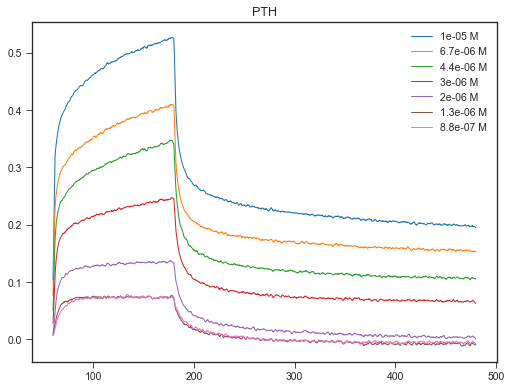

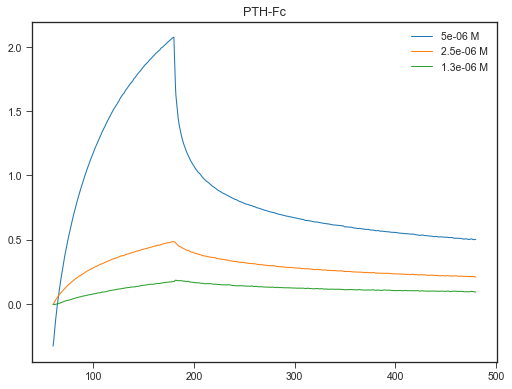

In [5]:
#sns.palplot(sns.color_palette("GnBu_d"))
k=0
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH-Fc")
    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH")
    k=k+1


# Model Description and Model Code 
This section of this notebook describes and provides the code for fitting different models to the data 


In [6]:
#this code is used throughout all of the fits so it is defined here 

#this peice of code is important. It locates the position where the tips are moved 
#from the PTH solution to plain buffer 
i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 

#parameters from BLI program's global fit for initial guess for one of the fittings 
#this provides a good starting point for all of the graphs 

kon = 9.32e4
kdis = 3.45e-2
Rmaxf = 0.1551 


print(max_index)

590


## One-to-One 

The one to one fitting follows the following model:  
$L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA$
The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]-k_d[LA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$

$\begin{equation}
R(t) = [LA](t)
\end{equation}$

The integrated equations that we will be fitting to the models are shown below 

for the absorption part: 

$R = R_{eq}(1-e^{-(k_aC+k_d)(t-t_0)})$

for the desportion part: 

$R=R_{0}e^{-k_d(t-t_0)}$

$R_{0} = R_{absFit}(t_{change over})$


$R_{eq} = \frac{k_aC}{k_aC+k_d}R_{max}$

So the variables varried in the fit are $R_{max}$, $k_d$ and $k_a$

In [7]:
#integrated version of the one-to-one fitting 
def oto_int(t,ka,kd,Rmax,A0,t0,tmax,imax):#absoprtion and desoprtion 
        np.zeros(len(t))
        tOnes = np.ones(len(t))
        isAbs = np.asarray(t)<tmax
        isDes =  np.invert(isAbs)
        Rest_abs = Rmax*((ka*A0)/(ka*A0+kd))*(1-np.exp(-(ka*A0+kd)*(t-t0)))
        R0 = Rest_abs[imax]
        Rest_des = R0*( np.exp(-kd*(t-tmax)))*isDes
        #print(t-tmax)
        
        return Rest_abs*isAbs +Rest_des*isDes
    
#for testing that this function works 
# t = np.linspace(0,5000,20000)
# ka = 5.959682e+04/100
# kd = 4.037493e-3

# Rmax = 4.242651e-03
# A0 = 1e-5
# t0 = 0 
# tmax = t[2000]
# print(tmax)
# imax = 2000

# sol =  oto_int(t,ka,kd,Rmax,A0,t0,tmax,imax)
# #print(len(sol))
# print(len(t))
# plt.plot(t,sol,'b--')    

In [8]:
#derivative version of the one-to-one fitting 
def oto_der(t,ka,kd,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0 = params 
        L,LA = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dL = -dLA
        
        f = [dL, dLA]
        return f 

    #paramaters 
    params = [kd,ka,A0]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA_abs = 0 
    conc0_abs = [L0_abs,LA_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_abs[:,1])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0]
    LA_des = Wtotal[-1]  
    conc0_des = [L0_des,LA_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1])

    #print(Wtotal)
    return Wtotal


## One-to-One model with a secondary interaction
Now that we have done the one-to-one fitting we move onto some other models. This model takes into account the secondary interactions between the probe and the solution. We will see if this ends up working.

The one to one fitting follows the following model:  
$L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA$

$L+S \underset{k_{as}}{\stackrel{k_{ds}}{\rightleftharpoons}} LS$

The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]-k_d[LA])- (k_as[L][S]-k_ds[LS])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$


$\begin{equation}
\frac{d[LS]}{dt}=k_as[L][A]-k_ds[LS]
\end{equation}$


$\begin{equation}
R(t) = [LA](t)+[LS](t)
\end{equation}$


In [9]:
def oto_sec_der(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0,kds,kas = params 
        L,LA,LS = conc 
        
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dLS = kas*A0*L - kds*LS
        dL = -dLA
        
        f = [dL, dLA,dLS]
        return f 

    #paramaters 
    params = [kd,ka,A0,kds,kas]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    LS0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs,LS0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1]+wsol_abs[:,2])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0,kds,kas]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    #print(len(wsol_abs))
    LS_des = wsol_abs[len(wsol_abs)-1,2]
    
    conc0_des = [L0_des,LA_des,LS_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1]+wsol_des[:,2])

    #print(Wtotal)
    return Wtotal

# #for testing that this function works 
# t = np.linspace(0,5000)
# ka = 5.959682e+04/100
# kd = 4.037493e-03
# kas = ka*1000
# kds = kd
# Rmax = 4.242651e-01
# A0 = 1e-6 
# t0 = 0 
# tmax = t[-1]
# imax = 20 

# sol =  oto_sec_der(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax)
# #print(len(sol))
# print(len(t))
# plt.plot(t,sol,'b--')

## one-to-one with second order secondary interaction with LA complex 

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]+k_d[LA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$

$\begin{equation}
\frac{d[LS]}{dt}=k_{as}[LA]^2[A]-k_{ds}[LS]
\end{equation}$

$\begin{equation}
R(t)=[LA](t)+[LS](t)
\end{equation}$


In [10]:
def oto_sLA2(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0,kds,kas = params 
        L,LA,LS = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dLS = kas*A0*LA**2 - kds*LS
        dL = -dLA
        
        f = [dL, dLA,dLS]
        return f 

    #paramaters 
    params = [kd,ka,A0,kds,kas]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    LS0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs,LS0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1]+wsol_abs[:,2])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0,kds,kas]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    #print(len(wsol_abs))
    LS_des = wsol_abs[len(wsol_abs)-1,2]
    
    conc0_des = [L0_des,LA_des,LS_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1]+wsol_des[:,2])

    return Wtotal

#for testing that this function works 
# t = np.linspace(0,5000)
# ka = 5.959682e+04/100
# kd = 4.037493e-03
# kas = ka*1000
# kds = kd
# Rmax = 4.242651e-01
# A0 = 1e-6 
# t0 = 0 
# tmax = t[-1]
# imax = 20 

# sol =  oto_sLA2(t,ka,kd,kas,kds,Rmax,A0,t0,tmax,imax)
# #print(len(sol))
# print(len(t))
# plt.plot(t,sol,'b--')

## one-to-one with a nonlinear response 
Fitting using the one-to-one binding model, but a nonlinear response of R to the binding 
model 3 is best described by the following set of equations 

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]+k_d[LA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$


$\begin{equation}
R(t)=[LA](t)+C2[LA](t)^2
\end{equation}$


In [11]:
def oto_nonlinear_der(t,ka,kd,Rmax,A0,t0,tmax,imax):
    abserr = 1.0e-8
    relerr = 1.0e-6
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0 = params 
        L,LA = conc 
        #ODEs 
        dLA = ka*A0*L - kd*LA 
        dL = -dLA
        
        f = [dL, dLA]
        return f 

    #paramaters 
    params = [kd,ka,A0]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    #print(len(wsol_abs))
    
    conc0_des = [L0_des,LA_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1])

    #print(Wtotal)
    return Wtotal

# #for testing that this function works 
# t = np.linspace(0,5000)
# ka = 5.959682e+04/100
# kd = 4.037493e-03
# C2 = 1e-3
# Rmax = 4.242651e-01
# A0 = 1e-6 
# t0 = 0 
# tmax = t[-1]
# imax = 20 
# sol =  np.array(oto_nonlinear_der(t,ka,kd,Rmax,A0,t0,tmax,imax))+C2*np.array(oto_nonlinear_der(t,ka,kd,Rmax,A0,t0,tmax,imax))**2

# #print(len(sol))
# print(len(t))
# plt.plot(t,sol,'b--')

## Bivalent analyte
The one to one fitting follows the following model:  
$2L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA + L\underset{k_{a2}}{\stackrel{k_{d2}}{\rightleftharpoons}} LLS$

The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = -(2k_{a}[L][A]-k_{d}[LA])-(k_{a2}[LA][L]-2k_{d2}[LLA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=(2k_{a}[L][A]-k_{d}[LA])-(k_{a2}[LA][L]-2k_{d2}[LLA])
\end{equation}$


$\begin{equation}
\frac{d[LS]}{dt}=(k_{2a}[LA][L]-2k_{d2}[LLA])
\end{equation}$


$\begin{equation}
R(t) = [LA](t)
\end{equation}$


In [12]:
def biAnalyte(t,ka,kd,ka2,kd2,Rmax,A0,t0,tmax,imax):
    
    abserr = 1.0e-12
    relerr = 1.0e-12
    t_abs = t[0:imax]
    t_des = t[imax:None]

    def deriv_LLa(conc,t,params):
        kd,ka,A0, ka2, kd2 = params 
        L,LA, LLA = conc 
        #ODEs 
        #dL = -(2*ka*L*A0-kd*LA)-(ka2*LA*L-2*kd*LLA)
        #dLA  = (2*ka*L*A0-kd*LA)-(ka2*LA*L-2*kd2*LLA)
        #dLLA = ka*LA*L-2*kd*LLA
        dL = -(2*ka*L*A0-kd*LA)-(ka2*LA*L-2*kd2*LLA)
        dLA = (2*ka*L*A0-kd*LA)-(ka2*LA*L-2*kd2*LLA)
        dLLA = (ka2*LA*L-2*kd*LLA)
        f = [dL, dLA, dLLA]
        return f 

    #paramaters 
    params = [kd,ka,A0,ka2,kd2]
    Wtotal = []

    #intial conditions for absorption section 
    L0_abs = Rmax
    LA0_abs = 0 
    LLA0_abs = 0 
    conc0_abs = [L0_abs,LA0_abs,LLA0_abs]
    wsol_abs = odeint(deriv_LLa, conc0_abs, t_abs, args=(params,),atol=abserr, rtol=relerr)
    Wtotal.extend(wsol_abs[:,1])

    #initial conditions for the desportion section 
    L0_des = 0
    params = [kd,ka,0,ka2,kd2]
    LA_des = wsol_abs[len(wsol_abs)-1,1]
    LLA_des =  wsol_abs[len(wsol_abs)-1,2]
    
    conc0_des = [L0_des,LA_des,LLA_des]
    
    wsol_des = odeint(deriv_LLa, conc0_des, t_des, args=(params,),atol=abserr, rtol=relerr)
    
    Wtotal.extend(wsol_des[:,1])

    #print(Wtotal)
    if(sum(np.array(Wtotal)<0)>0):
        return np.zeros(len(Wtotal))
    return Wtotal
#for testing that this function works 
# t = np.linspace(0,5000)
# ka = 2.425e3
# kd = 4.18e-3
# ka2 = 1.33e-2
# kd2 = 4.18e-3
# Rmax = 0.43
# A0 = 1e-6 
# t0 = 0 
# tmax = t[-1]
# imax = 20 
# sol =  np.array(biAnalyte(t,ka,kd,ka2,kd2,Rmax,A0,t0,tmax,imax))
# #print(len(sol))
# print(len(t))
# plt.plot(t,sol,'b--')


** model list: **

In [13]:
#change this when add additional models  

model_func_list = [oto_int,oto_der,oto_sec_der,oto_sLA2,oto_nonlinear_der,biAnalyte]
model_string_list = ["oto_int","oto_der","oto_sec_der","oto_sLA2","oto_nonlinear_der","biAnalyte"]

#model_func_list = [biAnalyte]
#model_string_list = ["biAnalyte"]


#don't change this 
model_dict = {}
for i in range(0,len(model_string_list)):
    model_dict[model_string_list[i]]=model_func_list[i]
#make a parameter list 



In [14]:
#fit all of the models to the data 
for run in run_array: 
    tp = np.array(run.t) #max index only fits first part 
    rp = np.array(run.r)
    A0 = float(run.concentration)
    t0 = tp[0]

    
    for key in model_dict: 
        aModel = Model(model_dict[key])
        if(key == "biAnalyte" and run.protein == "PTH"):
            continue
        #defines all of the parameters 
        params = aModel.make_params(value=kdis)
        params["kd"] = Parameter(name="kd",value=kdis,min=0)
        params["ka"] = Parameter(name="ka",value=kon,min=0)
        params["Rmax"] = Parameter(name="Rmax",value=Rmaxf,min=0)
        params["A0"] = Parameter(name="A0",value=A0,vary=False) 
        params["t0"] = Parameter(name="t0",value=t0,vary=False) 
        params["tmax"] = Parameter(name="tmax",value=tmax,vary=False) 
        params["imax"] = Parameter(name="imax",value=max_index,vary=False)
        if("kds" in params): #for the ones with as secondary interaction to prevent 0 rate constant
            params["kds"] = Parameter(name="kds",value=kdis,min=0)
            params["kas"] = Parameter(name="kas",value=kon,min=0)
            
        if("kd2" in params):
            ka = 2.425e3
            kd = 4.18e-3
            ka2 = 1.33e-2
            kd2 = 4.18e-3
            params["ka"] = Parameter(name="ka",value=ka,min=0)
            params["kd"] = Parameter(name="kd",value=kd,min=0)

            params["ka2"] = Parameter(name="ka2",value=ka2,min=0)
            params["kd2"] = Parameter(name="kd2",value=kd2,min=0)
            #print("This was called")

    
        result = aModel.fit(rp,params,t=tp)
        run.Rsqr[key] = 1 - result.residual.var() / np.var(rp)
        run.fitResult[key] = result
        

This was called


C:\Users\dexte\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


This was called
This was called
This was called
This was called
This was called
This was called
This was called
This was called
This was called
This was called
This was called


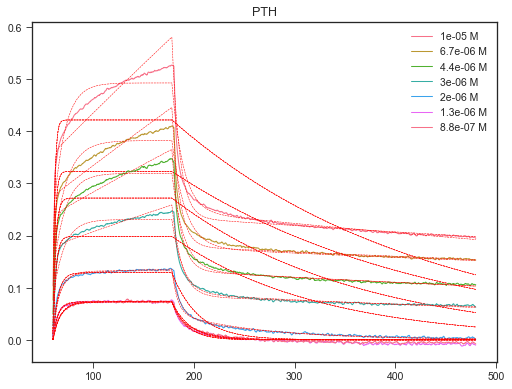

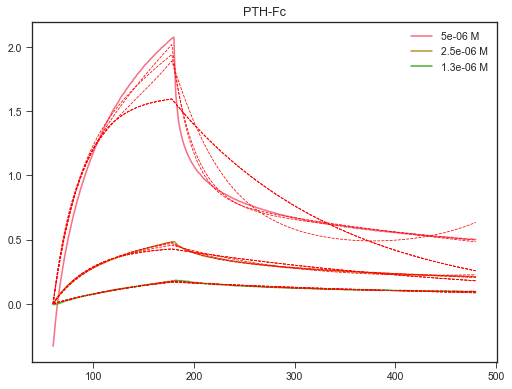

In [22]:
#now plot all of the data with a max nm shift above 0.07
runDictPTH = {} #usefull for plotting by concentration 
runDictPTHFc = {} 
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1.5,label=str(conc) + " M")
        for key in run.fitResult:
            plt.plot(run.t,run.fitResult[key].best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        runDictPTHFc[str(run.concentration)] = run 

        #print(run.fitResult.fit_report())
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        for key in run.fitResult:
            plt.plot(run.t,run.fitResult[key].best_fit,"--r",linewidth=0.5)
        plt.legend()
        plt.title("PTH")
        
        runDictPTH[str(run.concentration)] = run 



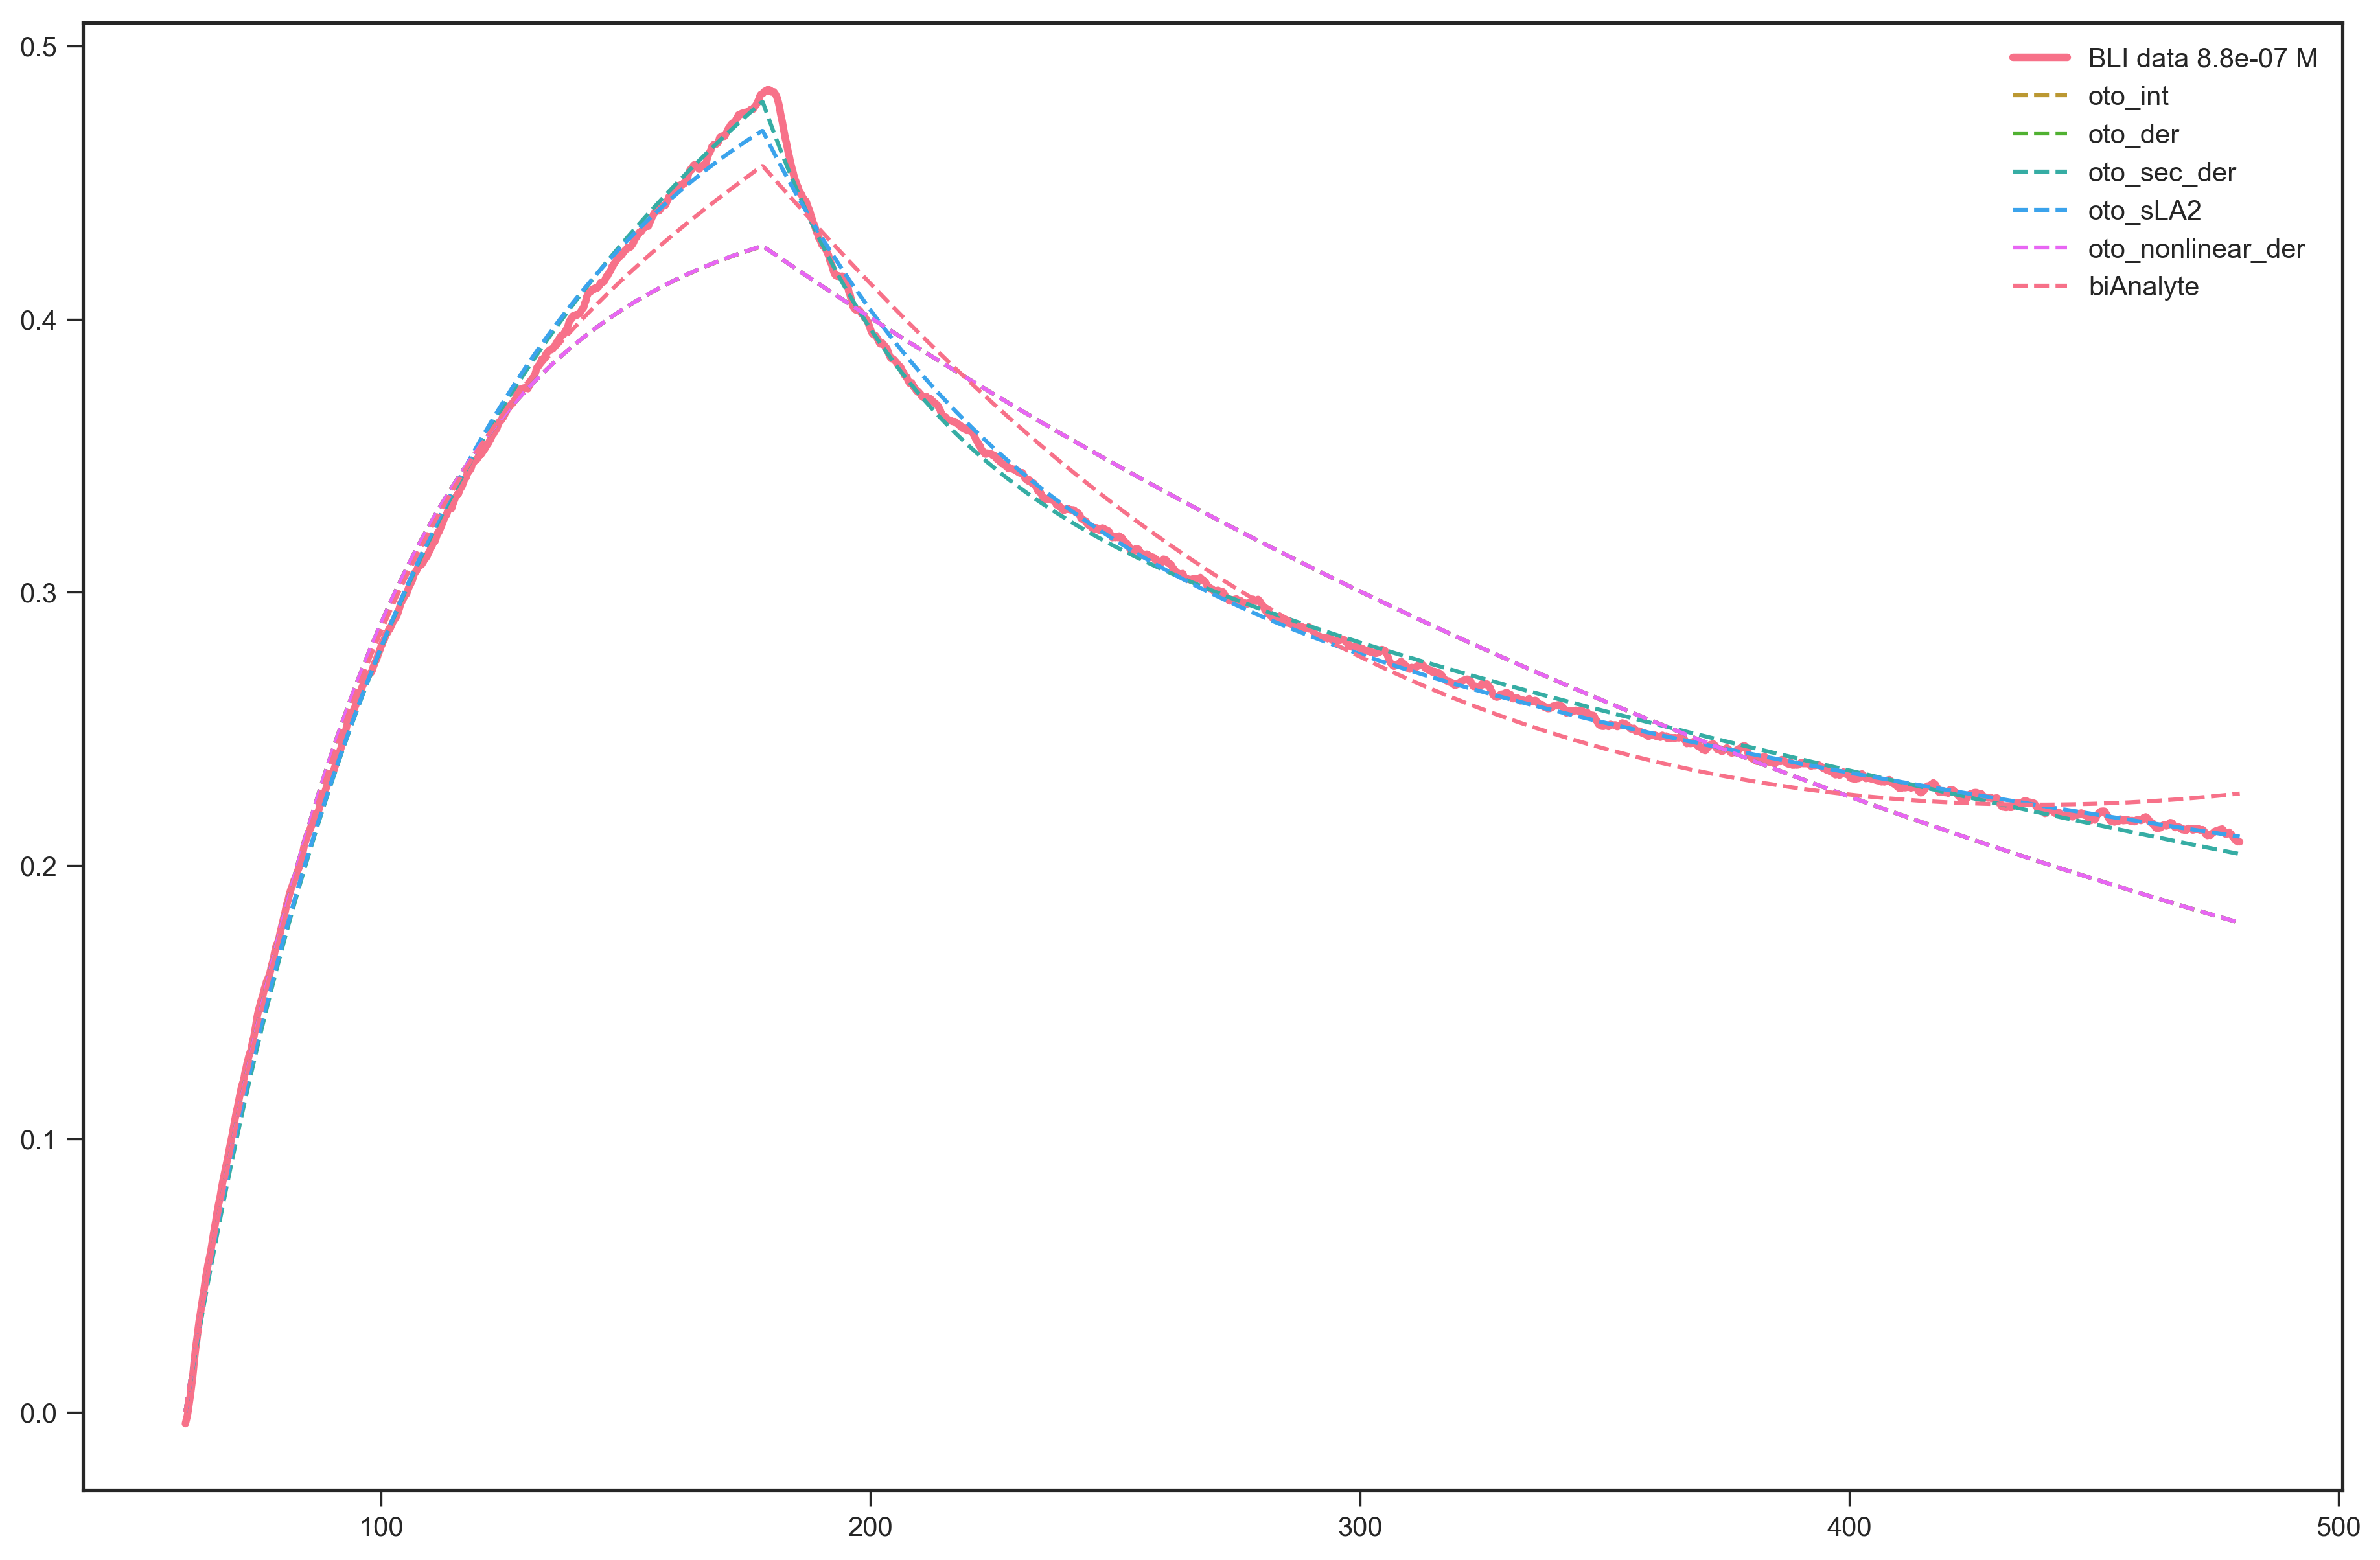

In [23]:

#compare fitting
#run = runDictPTH[str(8.8e-07)] #Change this value to change the fit that is plotted 
run = runDictPTHFc[str(2.5e-06)]

plt.figure(3,figsize=(15, 10), dpi=300, facecolor='w', edgecolor='k')

plt.plot(run.t,run.r,'-',linewidth=2.75,label="BLI data " + str(conc) + " M")
for key in run.fitResult:
    plt.plot(run.t,run.fitResult[key].best_fit,linewidth=1.5,label=key,linestyle="--")
        

plt.legend()



model being plotted selected is  oto_int


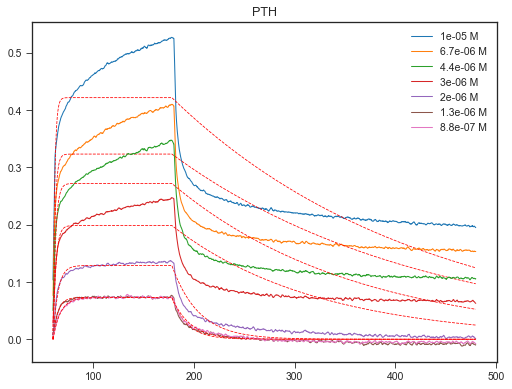

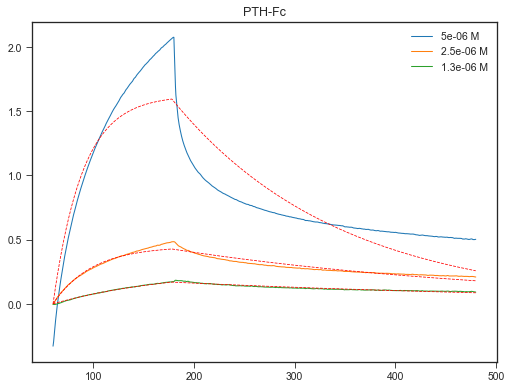

In [17]:
runDictPTH = {} #usefull for plotting by concentration 
runDictPTHFc = {} 
key = model_string_list[0] #choose the model to plot 
print("model being plotted selected is ", key)
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult[key].best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        runDictPTHFc[str(run.concentration)] = run 

        #print(run.fitResult.fit_report())
        #KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult[key].best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH")
        runDictPTH[str(run.concentration)] = run 

In [18]:
#now we process the data and put it into a pandas dataframe and then an excel sheet 
#make a nice pandas dataframe 
#in this we only 
#first make a dictionary
dataFrameList = []
keyList = []
output_m2 = {} #{"fileName","Protein Name","Concentration (M)","KD","ka","ka error","kd","kd error","Rmax","Rmax error","R^2"}
titleList = ["File Name","Protein Name","Concentration (M)","KD","ka","ka error","KD error","kd","kd error","Rmax","Rmax error","R^2"]
#initilize dictionary list
for key in model_dict:
    keyList.append(key)
    i = 0 
    for name in titleList:
        output_m2[name] = []
    #fill it with data 
    writer = pd.ExcelWriter('fittingOutput.xlsx', engine='xlsxwriter')
    for run in run_array:
        if(key in run.fitResult)
            fit = run.fitResult[key]


        output_m2["File Name"].append(fileNameList[i])
        output_m2["Protein Name"].append(run.protein)
        output_m2["Concentration (M)"].append(run.concentration)
        output_m2["KD"].append(fit.params["kd"].value/fit.params["ka"].value)
        output_m2["KD error"].append(0)
        output_m2["ka"].append(fit.params["ka"].value)
        output_m2["ka error"].append(fit.params["ka"].stderr)
        output_m2["kd"].append(fit.params["kd"].value)
        output_m2["kd error"].append(fit.params["kd"].stderr)


        #output_m2["kas"].append(fit.params["kas"].value)
        #output_m2["kas error"].append(fit.params["kas"].stderr)
        #output_m2["kds"].append(fit.params["kds"].value)
        #output_m2["kds error"].append(fit.params["kds"].stderr)


        output_m2["Rmax"].append(fit.params["Rmax"].value)
        output_m2["Rmax error"].append(fit.params["Rmax"].stderr)
        output_m2["R^2"].append(run.Rsqr[key])
        #print(run.Rsqr)
        #output["R^2"] =  1 - fit.residual.var() / np.var(y)
        i = i + 1 
    
    
    dataFrameList.append(pd.DataFrame.from_dict(output_m2))
    x = dataFrameList[-1]
    x["KD error"] = np.sqrt((x["kd error"]/x["kd"])**2 + (x["ka error"]/x["ka"])**2)*x["KD"]
    x["model"]=key
for i in range(0,len(dataFrameList)):
    dataFrameList[i].to_excel(writer,keyList[i])
    
writer.save()
completeDF = pd.concat(dataFrameList)
completeDF.head()

KeyError: 'biAnalyte'

# END OF CLEAN CODE